# Understanding my steps

Throughout this notebook if I've had an idea of how to improve performance, or done some hyper parameter optimisation, I've left the best values in as opposed to leaving previous iterations of the code or training performance in the notebook. This is mainly to avoid code repetion and lengthy training times whenever the notebook is reloaded. Whenever I've done this I've mentioned in the text what I've tried and whether it was better or worse.

For example, I found that including emojis in the tweets after preprocessing improved model performance so rather than running the code twice, one without emojis, I've only left the emoji-containing model.

All choices to do with model hyperparameters or features are decided by performance on a validation set. The final scores I present at the end are all calulated on a test set, which has been neither trained on nor used to make model choices.

# Exploring the data

Lets first import our data and have a look at it. We want to get a feel for how the dataset is distributed between the sentiment categories, whether we need to perform any normalization and what sort of metrics we have access to (for example, confidence).

Additionally we want to explore what each tweet contains at the world level: is it already preprocessed (and if not, what kind of preprocessing may be necessary), does it contain emojis, foreign languages, twitter handles and that sort of thing.

Lets import some tools to manage this, and the dataset itself.

In [1]:
import numpy as np
import pandas as pd

twitter_dataset = pd.read_csv( "data/tweets.csv" )
twitter_dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


`airline_sentiment` (Positive, Negative, Neutral) and `airline_sentiment_confidence` are our dependent variables and are obviously very important.

`negative_reason` may allow for some interesting extensions to the model, such as predicting reason, but we will ignore this for now. 

`user_timezone`, `tweet_location`, `tweet_created` and `tweet_coord` could all potentially be predictors for sentiment - its not hard to imagine that a tweet in the early hours of the morning could suggest a negative sentiment, for example.

`airline` could also be a predictor for sentiment. It's entirely plausible that people have biases against certain airlines because of experience or social media and this could influence the chance that any given tweet is negative. While this could improve performance on the task it could reduce its real world applicability as any analysis done by an airline company would be biased by their preexisting sentiment making it difficult to see new trends (or at least, any new trends would have a time delay).

`name` and `retweet_count` could be used with the `airline_sentiment_confidence` measures to rate how reliable or seriously a tweet should be taken by a company using the model. Tweets from a twitter user who consistently posts negative reviews may not be data that you wish to include in your analysis since it could suggest somebody that complains no matter what which skews the analysis such that overall attitude towards you is lower than it actually is. Conversely, `retweet_count` could imply a more reliable opinion as each retweet esentially endorses that opinion. Having said all of this, `name` and `retweet_count` likely aren't useful in predicting sentiment of any one tweet (with `name`, we don't have enough data points for each user to generate a sentiment for them) and so we will ignore them.

`text` is the body of the tweet and will make up the dataset used to fine tune our language model and the bulk of our sentiment prediction. It appears to be totally unprocessed so we will do that ourselves.

Lets have a look at how many datapoints we have for each sentiment category and how the confidence is distributed.

In [2]:
pos_t = twitter_dataset.loc[twitter_dataset['airline_sentiment'] == 'positive']
neg_t = twitter_dataset.loc[twitter_dataset['airline_sentiment'] == 'negative']
neut_t = twitter_dataset.loc[twitter_dataset['airline_sentiment'] == 'neutral']

for sentiment, values in { 'pos': pos_t, 'neg': neg_t, 'neut': neut_t }.items():
    confidence = values['airline_sentiment_confidence'].to_numpy()
    bins = np.linspace( confidence.min(), confidence.max(), 11 )
    bin_counts = [ len( np.where( ( confidence >= i ) & ( confidence <= bins[n+1] ) )[0] ) for n, i in enumerate( bins[:-1] ) ]

    print(  f'{sentiment} counts:', list( zip( np.round( bins[:-1], 2 ), bin_counts ) ), len( confidence ) )

pos counts: [(0.34, 71), (0.4, 0), (0.47, 0), (0.53, 0), (0.6, 384), (0.67, 392), (0.73, 0), (0.8, 0), (0.87, 1), (0.93, 1516)] 2363
neg counts: [(0.34, 63), (0.41, 0), (0.47, 1), (0.54, 1), (0.6, 906), (0.67, 816), (0.74, 2), (0.8, 1), (0.87, 5), (0.93, 7386)] 9178
neut counts: [(0.34, 102), (0.4, 0), (0.47, 0), (0.53, 0), (0.6, 730), (0.67, 718), (0.73, 0), (0.8, 0), (0.87, 1), (0.93, 1549)] 3099


The vast majority of datapoints have at least 93% confidence for all sentiment categories and we don't find many data points until we go all the way down to 60-67% confidence. The lower the confidence of the datapoints we use, the more noise we introduce into the model which can potentially reduce our performance. 

As it turns out, only training on high confidence data does little to improve our performance and in some cases even makes it worse. This could be because there are comparitively few low confidence examples, so the performance we would gain in removing them is offset by the reduction in the amount of training data. Our assumption that low confidence = noise could also be flawed: low confidence predictions may still be quite accurate and so removing them takes away useful data.

Perhaps a larger problem is the number of datapoints we have for each sentiment category. Negative sentiment dominates the dataset. This can lead to weaker performance when classifing the minority classes. Once again, we find that a simple downsampling approach (sample N examples from all categories where N is the size of the smallest category) actually hurts model performance. We perhaps need a more advanced resampling technique, or maybe the imbalance is not a problem. We do find that performance on the largest category (negative) is best but that is to be expected.

# Preprocessing the twitter dataset

Lets load in the raw text of all the tweets so we can preprocess them for the language model. At this point, we don't need to split by sentiment category since the language model only cares for the structure of the language itself. We'll shuffle the data just in case there was any structure. Additionally, we want to add a special 'new field' token to the start of each tweet. Since the language model sees all tweets as one big block of text it is useful to let the model know when to 'forget' the context of the previous tweet (we borrow this idea from the fast.ai text preprocessing code, which we will use later to further preprocess the text).

In [3]:
BOS = 'xxbos'

tweets_pre = twitter_dataset[['text','airline_sentiment','airline_sentiment_confidence']].to_numpy()
np.random.shuffle( tweets_pre )

tweets = []
for t_text, sentiment, confidence in tweets_pre:
    tweets.append( [ f'{BOS} {t_text}', sentiment, confidence ] )
    
tweets = np.array( tweets )

Now lets preprocess the text properly. We're going to use the fast.ai text preprocessing library since it offers us a bunch of useful built-in preprocessing steps and allows us to add in our own. We're also going to use the fast.ai library later on to train the language model as it has library support for ULMFiT (and the AWD-LSTM) so it makes sense to use the same library.

We're going to use the default preprocessing steps from fast.ai which revolve around adding special tokens, or modifiers, instead of removing information. For example, in NLP you would usually lowercase everything since, to a language model, 'language' and 'Language' are two different words and would therefore have different training data, potentially reducing the model performance with both variations. Fast.ai circumvents this by lowercasing all words but adding a 'this word was uppercased' modifier token ('xxup') which the language model can learn the semantics of. There are a bunch of these tokens for different circumstances, I won't go in to all of them.

We're going to borrow this idea for some domain-specific formatting that we wish to learn the semantics of. The earlier analysis of the tweet data showed a few things we need to deal with: emojis, misspelling, hashtags, mentions and urls.

**Mentions** could be used to try and predict sentiment based off the sentiment of the person/tweet that is being responded to, but for now we're just going to remove them.

**Emojis**, I predict, will be a very good predictor of sentiment with the caveat that sometimes people use emojis sarcastically to actually mean the opposite thing. Nevertheless, it would be useful to include these in the language model. Since there isn't a natural conversion between emojis and normal text, we won't use a modifier on these but instead will use the `emoji` library to convert them in to human-readable tokens of the form `:emoji_description:`, which the language model will just treat as another word to be learned.

**Hashtags** are often just words, like '#annoyed', so we can format them as a word with a 'hashtag' modifier ('xxhst') that the language model will learn the semantics of. Hashtags which don't appear in normal text don't really benefit from this, as the hashtag modifier is just modifying a word we have little knowledge of. If the hashtag frequency is below the minimum frequency (which we will set later) then it'll be removed, otherwise there are likely enough examples that some semantics can be determined.

**Miss-spellings** are an interesting one. Tweets, because of their short-form format, are likely written quite fast with comparitvely less care than some longer form documents and are also usually written with a mobile device. All of this, I think, leads to an increase in spelling errors. We want to remove these so our dataset is not split on the same word (same reason we lowercase everything) but you could argue that a misspell could correlate with sentiment - you're probably going to type _even faster_ and with more errors if you're angry. To take this in to account, we add a 'misspelled' modifier token ('xxmsp') before every corrected word. Its also possible that the spell corrections will reduce model accuracy, since no spell checker is perfect and sometimes miscorrects things. We can check this later on our validation set. For spell checking we're going to use the `jamspell` library.

**URLs** could be followed and a secondary model predicts the sentiment of the followed link, but thats well beyond the scope of this task, so we'll remove URLs also.

In [77]:
import re
import jamspell
from emoji import demojize
from fastai import text

def get_all_emojis( t ):
    t = demojize( ' '.join( t ) )
    return list( set( re.findall( r'(:\w+:)', t ) ) )

HASHT = 'xxhst'
MSPELL = 'xxmsp'

special_tokens = text.defaults.text_spec_tok + [ HASHT, MSPELL ] + get_all_emojis( tweets[:,0] )
special_tokens_set = set( special_tokens )

def fix_spelling():
    c = jamspell.TSpellCorrector()
    c.LoadLangModel('data/en.bin')
    
    def _fix_spelling( t, ignore_hashtags = True, add_modifier = True ):    
        res = []
        skipnext = False
        for token in t:
            if ( token not in special_tokens_set ) and not skipnext:
                token_fixed = c.FixFragment( token )
                if token != token_fixed:
                    if add_modifier:
                        res.append( MSPELL )
                    token = token_fixed

            res.append( token )
            skipnext = False

            if ignore_hashtags and token == HASHT:
                skipnext = True

        return res
    
    return _fix_spelling
    
def demojify( t, remove = False ):
    t = demojize( t )
    if remove:
        return re.sub( r'(:\w+:)', '', t )
    else:
        return re.sub( r'(:\w+:)', r' \1 ', t )

def modify_hashtags( t ):
    return re.sub( r'#{1}(\w+)', lambda m: f' {HASHT} {m.group(1)} '.lower().replace( '_', '' ), t )

def remove_handles( t ):
    return re.sub( r'@{1}(\w{1}){1,15}', '', t )

def remove_urls( t ):
    return re.sub( r'((http)|(https))(:\/\/)((www\.)?)([a-zA-Z0-9]+)((\.[a-z]+)+)(\/(\w+))*(\/?)', '', t )

pre_rules = [ remove_handles, remove_urls, modify_hashtags, demojify ] + text.defaults.text_pre_rules
post_rules = text.defaults.text_post_rules + [ fix_spelling() ]

tokenizer = text.Tokenizer( pre_rules = pre_rules, post_rules = post_rules, special_cases = special_tokens )

We find that emojis do help to improve model performance of the final model, as do removing handles and urls. Having said that though, these are small (1-2%) improvements and could be statistically irrelevant given our validation set size (10%=~1500 examples) and random sampling.

Modifying hashtags and fixing spelling, surprisingly, have absolutely no effect on performance, either good or bad. I leave them here regardless, but they could (and likely should, to make the model simpler) be removed. 

Modified hashtags probably had no effect since for dictionary words, the word alone is enough to imply sentiment (e.g. #annoyed) and therefore the hashtag modifier doesn't learn much sentiment. For non-dictionary words, most of them probably got removed in the min_freq step (where we remove any tokens that have a frequency less than 2) and the few that remained did not contribute enough to the language model to drastically change the result.

Fixing spelling could have counteracted itself by improving performance for correctly fixed words but then worsening performance on incorrectly fixed words. Perhaps with a more robust spell checker, taking in to account context, this could have been improved. Interestingly, the same idea used in ULMFiT - fine tuning on the target dataset - could also be applied to a spell checker. That way we could not only take in to account context (provided for by the LSTM) but also domain-specific misspellings. Could be an interesting extension to the project, however I don't think even a perfect spell checker would increase the model performance enough to warrant the effort.

In [78]:
from sklearn.model_selection import train_test_split

def sample_equally( dataset, groupby_ind ):
    dataset_pd = pd.DataFrame( dataset )

    g = dataset_pd.groupby( groupby_ind )
    g = pd.DataFrame( g.apply( lambda x: x.sample( g.size().min() ).reset_index( drop = True ) ) )

    return g.to_numpy()

tweets_tokenized = tokenizer._process_all_1( tweets[:,0] )
tweets_all = np.array( [ [ tweets_tokenized[n], t[1], t[2] ] for n, t in enumerate( tweets ) ] )

t_train, t_val_test = train_test_split( tweets_all, test_size = 0.2 )
t_val, t_test = train_test_split( t_val_test, test_size = 0.5 )

lm_train, lm_val = t_train[:,0], t_val[:,0]
clas_train, clas_val, clas_test = t_train[:,0:2], t_val[:,0:2], t_test

Now we can split the dataset in to the training (80%), validation (10%) and test (10%) sets. `train_test_split` will shuffle these so we can be doubly sure, with our shuffle earlier, that we eliminate any structure.

We deliberately use 3 sets here since if we modify the parameters of the model based on validation set performance, we can inadvertently leak information back to the model which will bias our eventual score, almost as if we had overfit on the training set. To combat this, we only ever report final model performance on a test set, which we never optimise the model for.

I've also included the `sample_equally` function which is used to downsample the dataset. Its use doesn't actually increase model performance so we avoid using it here.

Lets have a look at the text now that its been processed. We want to pay particular attention to the frequency of things like emojis and our custom modifier tags - are there enough examples to warrant their use or are they just added noise?

In [79]:
for i in np.random.choice( lm_train, 10 ):
    print( ' '.join( i ) )

xxbos also checked email you have on file for me and it is correct
xxbos this very pregnant lady 's hoping & & praying hubbys flight from xxup bwi gets off the ground ! i 'd like him to get here before baby does !
xxbos xxup worst customer service ever ! ! !
xxbos what you did was illegal and a breach of contract . i will be in touch but not through your " customer feedback "
xxbos yes please ! i am newly married and trying to update my last name on a preexisting international flight ! xxmaj it seems so easy , but ...
xxbos i have a xxmaj cancelled xxmaj flighted flight tomorrow morning and the 800 number did nothing ! xxmaj please ! i just want to go home !
xxbos xxmaj thanks - it 's very helpful to understand that the reduced price seats that are sold at check - in have priority over the certificates .
xxbos i dunno my travel information .. like what ?
xxbos i 'll be impressed if i actually get a response ! :winking_face_with_tongue:
xxbos xxmaj hey why automated call me and then han

In [80]:
from collections import Counter

def list_special_tokens( counts ):
    tokens = []
    for i in counts:
        if i[0] in special_tokens_set:
            tokens.append( i )
            
    return tokens
        
token_counts = Counter( token for tweet in lm_train for token in tweet )

print( 'Special token counts:' )
for p in list_special_tokens( token_counts.most_common() ): print( p )
    
print( '\nVocab count:', len( token_counts.most_common() ) )

Special token counts:
('xxmaj', 18114)
('xxbos', 11712)
('xxup', 5426)
('xxhst', 2832)
('xxmsp', 1517)
('xxrep', 314)
(':face_with_tears_of_joy:', 46)
(':airplane:', 37)
(':folded_hands:', 35)
(':loudly_crying_face:', 34)
(':thumbs_up:', 29)
(':clapping_hands:', 26)
(':red_heart:', 25)
(':smiling_face_with_smiling_eyes:', 25)
(':pouting_face:', 20)
(':thumbs_down:', 16)
(':beaming_face_with_smiling_eyes:', 16)
(':weary_face:', 16)
(':winking_face:', 16)
(':unamused_face:', 16)
(':victory_hand:', 15)
(':grinning_face_with_big_eyes:', 15)
(':crying_face:', 13)
(':blue_heart:', 9)
('xxwrep', 9)
(':party_popper:', 8)
(':growing_heart:', 8)
(':grinning_face_with_smiling_eyes:', 8)
(':pensive_face:', 7)
(':raising_hands:', 7)
(':confused_face:', 7)
(':winking_face_with_tongue:', 6)
(':ribbon:', 6)
(':smiling_face:', 6)
(':expressionless_face:', 6)
(':face_with_steam_from_nose:', 5)
(':grinning_face:', 5)
(':eyes:', 5)
(':smiling_face_with_sunglasses:', 5)
(':disappointed_face:', 5)
(':pile_o

It seems there are a fair few emojis that only appeared once, but also a lot that appeared frequently. Our custom modifier tokens also were quite frequent (especially misspellings!) so there should be enough data to learn any semantic properties.

Now we will set up the dataset to be fed in to the language model LSTM.

In [81]:
from collections import defaultdict

min_freq = 2

itos = [ token for token, freq in token_counts.most_common() if freq >= min_freq ]
itos.insert( 0, 'xxunk' )
stoi = defaultdict( lambda: 0, { string: ind for ind, string in enumerate( itos ) } )

tweets_train_lm = np.array( [ [ stoi[token] for token in tweet ] for tweet in lm_train ] )
tweets_val_lm = np.array( [ [ stoi[token] for token in tweet ] for tweet in lm_val ] )

print( 'Vocab count:', len( itos ) )

Vocab count: 5636


`min_freq` is set to 2 as any token that only appears once will have an unreliable encoding, totally dependent on the one context it appeared in. 

We have quite a small vocab so training should be fast at least. For reference the WikiText-103 model which we're going to use next has a vocabulary of almost 300000.

# Pretraining a language model

One of the key insights of the ULMFiT model is to pretrain the language model on a large, more general dataset and to then fine tune on the target dataset. The ULMFiT paper chose to use the WikiText-103 dataset which is a large collection of English language wikipedia articles. This dataset is a pretty universal dataset for the English language so I'm going to use it for this task as well. There exists pretrained AWD-LSTMs for this dataset which I will use as the basis for my language model. `language_model_learner` automatically downloads and loads these pretrained weights through the `AWD_LSTM` model.

The big breakthroughs that made the ULMFiT approach so powerful, aside from the pretraining, are in how they deal with the fine tuning steps: triangular learning rates, discriminative fine-tuning, gradual unfreezing and the use of the AWD-LSTMs. This is all abstracted away when using the fast.ai library code which I won't explain as I'd just be repeating the paper.

In [82]:
vocab = text.transform.Vocab( itos )
lm_db = text.data.TextLMDataBunch.from_ids( path = 'nn/lm/', vocab = vocab, train_ids = tweets_train_lm, valid_ids = tweets_val_lm)

lm_learn = text.learner.language_model_learner( lm_db, text.models.AWD_LSTM, drop_mult = 0.3 )

For the language model fine tuning, we generally stick to the default values given in the ULMFiT paper/fasti.ai tutorials. In particular, the `drop_mult` and `moms` arguments are left as default. Cycle length (`cyc_len`) and learning rate (`max_lr`) are optimised based on validation set performance (and the `lr_find()` function for learning rate) since our dataset is quite different to the IMDB dataset that ULMFiT was originally trained on. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


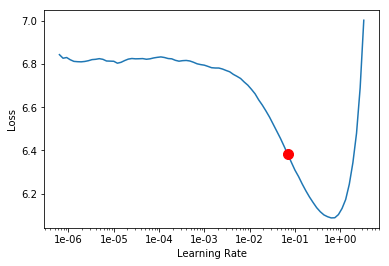

In [83]:
lm_learn.lr_find()
lm_learn.recorder.plot()

In [84]:
lm_learn.fit_one_cycle( cyc_len = 1, max_lr = 8e-03, moms = ( 0.8, 0.7 ) )

epoch,train_loss,valid_loss,accuracy
1,5.330698,4.624245,0.211858


epoch,train_loss,valid_loss,accuracy
1,4.379672,4.227728,0.239286
2,4.054000,3.910035,0.274721
3,3.722857,3.896523,0.280218


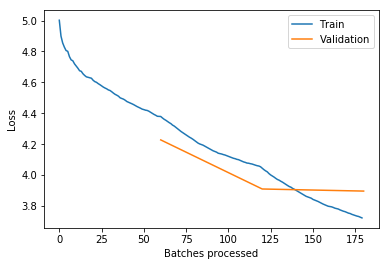

In [85]:
lm_learn.unfreeze()

lm_learn.fit_one_cycle( cyc_len = 3, max_lr = 3e-03, moms = ( 0.8, 0.7 ) )
lm_learn.recorder.plot_losses()

lm_learn.save_encoder( 'fine_tuned_enc' )

Optimal `valid_loss` seems to hover between 3 and 4 epochs. We'll leave it at 4 here.

Now we have our fine tuned language model, we can train our classifier.

# Training a classifier

In [86]:
clas_train_tok, clas_train_lbl = clas_train[:,0], clas_train[:,1]
clas_val_tok, clas_val_lbl = clas_val[:,0], clas_val[:,1]
clas_test_tok = clas_test[:,0]

clas_db = text.data.TextClasDataBunch.from_tokens( path = 'nn/lm/', vocab = vocab, trn_tok = clas_train_tok, val_tok = clas_val_tok, tst_tok = clas_test_tok, trn_lbls = clas_train_lbl, val_lbls = clas_val_lbl, min_freq = 2 )

In [87]:
clas_learn = text.learner.text_classifier_learner( clas_db, text.models.AWD_LSTM, drop_mult = 0.5 )
clas_learn.load_encoder( 'fine_tuned_enc' )

Once again, we leave `drop_mult`, `moms` and `max_lr` at their default values, instead using our validation set to optimise for `cyc_len`.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


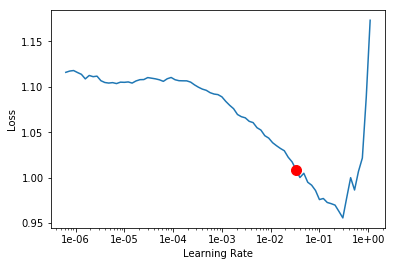

In [88]:
clas_learn.lr_find()
clas_learn.recorder.plot()

In [89]:
clas_learn.fit_one_cycle( cyc_len = 3, max_lr = 1e-02, moms = ( 0.8, 0.7 ) )

epoch,train_loss,valid_loss,accuracy
1,0.766171,0.564554,0.765027
2,0.726841,0.550908,0.762295
3,0.688291,0.540922,0.775273


In [90]:
clas_learn.freeze_to( -2 )
clas_learn.fit_one_cycle( cyc_len = 4, max_lr = slice( 1e-2/(2.6**4), 1e-2 ), moms = ( 0.8, 0.7 ) )

epoch,train_loss,valid_loss,accuracy
1,0.703883,0.541981,0.778005
2,0.657644,0.505638,0.795082
3,0.624557,0.488149,0.797131
4,0.617407,0.508540,0.787568


In [91]:
clas_learn.freeze_to( -3 )
clas_learn.fit_one_cycle( cyc_len = 3, max_lr = slice( 5e-3/(2.6**4), 5e-3 ), moms = ( 0.8, 0.7 ) )

epoch,train_loss,valid_loss,accuracy
1,0.584191,0.480091,0.816940
2,0.593061,0.458295,0.816257
3,0.514135,0.452296,0.822404


In [92]:
clas_learn.unfreeze()
clas_learn.fit_one_cycle( cyc_len = 4, max_lr = slice( 1e-3/(2.6**4), 1e-3 ), moms = ( 0.8, 0.7 ) )

epoch,train_loss,valid_loss,accuracy
1,0.502921,0.467433,0.818306
2,0.501923,0.452094,0.821721
3,0.509733,0.459230,0.814891
4,0.484913,0.454741,0.824454


# An analysis of the results

We're going to define a bunch of lists based on the test set. There aren't any built in functions (that I can find) for calculating metrics on test set data in fast.ai, so we'll do it manually. We also want to look at model confidence (probability for each class) and the confidence found in the twitter dataset itself.

In the following analysis, class '0' means negative, class '1' neutral and class '2' positive.

In [93]:
from fastai import basic_data

class_str_map = { 'negative': 0, 'neutral': 1, 'positive': 2 }
test_pred = clas_learn.get_preds( ds_type = basic_data.DatasetType.Test, ordered = True )
test_pred_class = [ np.argmax( i ) for i in test_pred[0].numpy() ]
test_pred_class_p = [ i[np.argmax( i )] for i in test_pred[0].numpy() ]
test_pred_truth = [ class_str_map[i] for i in clas_test[:,1] ]
test_pred_truth_p = clas_test[:,2].astype( float )

test_acc = np.average( [ int( pred == true ) for pred, true in zip( test_pred_class, test_pred_truth ) ] )
print( 'Test Accuracy:', test_acc )

Test Accuracy: 0.819672131147541


And now we have our final accuracy on the test set, **82.0%**. Its quite difficult to find the accuracy of other models using this dataset. I have found a range of accuracy from 75% all the way up to 95%, although I can't comment on the reliability of those scores. Nevertheless, we have at least beat _some_ scores! 

Having said that though, accuracy is not a good metric for this task, especially since we know we have a class imbalance problem. Lets look at some others.

In [94]:
test_acc_conf_data = np.average( [ int( pred == true ) for pred, true, conf in zip( test_pred_class, test_pred_truth, test_pred_truth_p ) if conf >= 0.85 ] )
test_acc_conf_model = np.average( [ int( pred == true ) for pred, true, conf in zip( test_pred_class, test_pred_truth, test_pred_class_p ) if conf >= 0.85 ] )
print( 'Test accuracy on high (P>=0.85) confidence test data:', test_acc_conf_data )
print( 'Test accuracy on high (P>=0.85) confidence model predictions:', test_acc_conf_model )

Test accuracy on high (P>=0.85) confidence test data: 0.9078694817658349
Test accuracy on high (P>=0.85) confidence model predictions: 0.9241025641025641


Test accuracy on high confidence model predictions are obviously higher since we are only looking at predictions the model is sure of. Its not practically useful since we can't just decide to not predict a class based on a low prediction confidence.

The test accuracy on high confidence test data (datapoints in the original dataset with high confidence) is a little more useful as it shows us the model performs much better on unambiguous datapoints (although, again, that was to be expected).

In [95]:
for k, v in class_str_map.items():
    avg_conf_by_cls = np.average( [ conf for true, conf in zip( test_pred_truth, test_pred_class_p ) if true == v ] )
    print( f'Average confidence for {k} class:', avg_conf_by_cls )

Average confidence for negative class: 0.89689
Average confidence for neutral class: 0.7901
Average confidence for positive class: 0.84029096


We can see here that the model is a lot more confident predicting the negative class, which was to be expected given the class imbalance. More surprising is the difference in performance between neutral and positive classes. The dataset contained more neutral tweets than positive (the smallest class) which suggests some overall ambiguity in neutral tweets. Neutrality being the lack of any sentiment probably meant the classifier was more influenced by incorrect sentiment for a token as it did not have any other sentiment signals to drown out the noise (a negative tweet may have some positive words, but the negative sentiment words will be dominant, whereas for a neutral tweet a positive word will skew the whole tweet towards being positive).

Its also possible that neutral tweets were just harder to label when constructing the dataset and so the quality of the neutral tweet data is reduced compared to positive and negative.

Lets have a look at some more metrics. I created a class to handle different metrics used in creating confusion matrices, ROC curves and the like.

In [96]:
import matplotlib.pyplot as plt
from fastai import basic_data
import itertools
from sklearn.metrics import roc_curve, auc

class ConfusionMetrics:
    def __init__( self, pred, truth, n_class = 3, class_names = None ):
        self.pred = pred
        self.truth = truth
        self.n_class = n_class
        self.class_names = class_names
        self.predicted_as = np.zeros( ( n_class, n_class ) )
        
        self._bin_predictions()
        
    def _bin_predictions( self ):
        for pred_i, truth_i in zip( self.pred, self.truth ):
            self.predicted_as[truth_i][pred_i] += 1
            
    def _plot_matrix( self, c_matrix, class_names ):
        ## plot code borrowed from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        plt.imshow( c_matrix, interpolation = 'nearest', cmap = plt.cm.Blues )
        plt.colorbar()
        tick_marks = np.arange( len( c_matrix ) )
        plt.xticks( tick_marks, class_names, rotation = 45 )
        plt.yticks( tick_marks, class_names )

        thresh = c_matrix.max() / 2.
        for i, j in itertools.product( range( c_matrix.shape[0] ), range( c_matrix.shape[1] ) ):
            plt.text( j, i, format( c_matrix[i, j] ),
                     horizontalalignment = "center",
                     color = "white" if c_matrix[i, j] > thresh else "black" )

        plt.ylabel( 'True label' )
        plt.xlabel( 'Predicted label' )
            
    def confusion_matrix( self, normalized = False, plot = False ):
        c_matrix = self.predicted_as
        if normalized:
            c_matrix = np.round( c_matrix / np.sum( c_matrix, axis = 1 ).reshape( 3, 1 ), 2 )
            
        if plot:
            self._plot_matrix( c_matrix, self.class_names )
        else:
            return c_matrix
            
        
class BinaryConfusionMetrics( ConfusionMetrics ):
    def __init__( self, pred, truth, cls_prob = None, n_class = 3, class_names = None ):
        super( BinaryConfusionMetrics, self ).__init__( pred, truth, n_class, class_names )
        
        self.cls_prob = cls_prob
        self.metrics = np.zeros( ( n_class, 4 ) )  # [ tp, fn, fp, tn ] for each class
        self._get_confusion_metrics()
    
    def _get_confusion_metrics( self ):
        for cls in range( self.n_class ):
            tp = self.predicted_as[cls][cls]
            fp = np.sum( self.predicted_as[:, cls] ) - tp
            fn = np.sum( self.predicted_as[cls] ) - tp
            tn = np.sum( self.predicted_as ) - tp - fp - fn
            self.metrics[cls] = [ tp, fn, fp, tn ]
    
    def recall( self, cls ):
        return self.metrics[cls][0] / ( self.metrics[cls][0] + self.metrics[cls][1] )
    
    def precision( self, cls ):
        return self.metrics[cls][0] / ( self.metrics[cls][0] + self.metrics[cls][2] )
    
    def f1( self, cls ):
        return 2 * ( ( self.precision( cls ) * self.recall( cls ) ) / ( self.precision( cls ) + self.recall( cls ) ) )
    
    def confusion_matrix( self, cls, normalized = False, plot = False ):
        c_matrix = self.metrics[cls].reshape( ( 2, 2 ) )
        class_names = [ f'class {cls}', f'not class {cls}' ]
        if normalized:
            c_matrix = np.round( c_matrix / np.sum( c_matrix, axis = 1 ).reshape( 2, 1 ), 2 )
            
        if plot:
            self._plot_matrix( c_matrix, class_names )
        else:
            return c_matrix
        
    def roc_curve( self, cls ):
        ## borrowed from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        binary_prob = self.cls_prob[:,cls]
        
        fpr, tpr, thresholds = roc_curve( y_true = self.truth, y_score = binary_prob, pos_label = cls )
        roc_auc = auc( fpr, tpr )
        
        lw = 2
        plt.plot( fpr, tpr, color = 'darkorange',
                 lw = lw, label='ROC curve (area = %0.2f)' % roc_auc )
        plt.plot( [0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--' )
        plt.xlim( [0.0, 1.0] )
        plt.ylim( [0.0, 1.05] )
        plt.xlabel( 'False Positive Rate' )
        plt.ylabel( 'True Positive Rate' )
        plt.title( f'Class {cls} ROC Curve' )
        plt.legend( loc = "lower right" )

class_ind_map = [ 'negative', 'neutral', 'positive' ]
metrics = ConfusionMetrics( test_pred_class, test_pred_truth, class_names = class_ind_map )
b_metrics = BinaryConfusionMetrics( test_pred_class, test_pred_truth, cls_prob = test_pred[0].numpy() )

print( 'Precision/Recall/F1:' )
for i in range( 3 ):
    print( f'{class_ind_map[i]}:', b_metrics.precision( i ), b_metrics.recall( i ), b_metrics.f1( i ) )

Precision/Recall/F1:
negative: 0.8630412890231621 0.9254859611231101 0.8931735278791036
neutral: 0.7379912663755459 0.5522875816993464 0.6317757009345796
positive: 0.71900826446281 0.75 0.7341772151898734


As expected, negative sentiment dominates the precision and recall (and F1) metrics (likely) due to the dataset imbalance. I would argue this is not necessarily a bad thing: a real world application for this model could be an airline company trying to detect negative sentiment towards them so they can improve their PR response, respond quickly to some fast developing PR issue and the like. As such, they would prioritise detecting as much negative sentiment as possible (recall) so they don't miss anything and as accurately as possible (precision) so they don't waste their time.

Positive comes up second again, probably for the same reasons detailed above. Interesting to note here that positive and neutral have similar precisions suggesting that, when the model does decide something is positive or neutral, its quite accurate. Neutral however falls down in recall by missing a lot of neutral responses. This, I would argue, is evidence that the neutral tweet sentiment is skewed towards the few noise words that appear in all tweets since it has no sentiment of its own to counteract this.

The performance of negative is quite skewed by the dataset imbalance. We can see that a lot of the neutral tweets were missed (0.54 recall) which have to be absorbed by one of the other two classes. Since there are so many negative tweets, absorbing (for example) 50 neutral tweets when negative has (for example) 1000 will barely change the precision at all, which could explain why the precision for negative (and positive) is lower than its recall.

We can plot some confusion matrices and ROC curves to further visualize this.

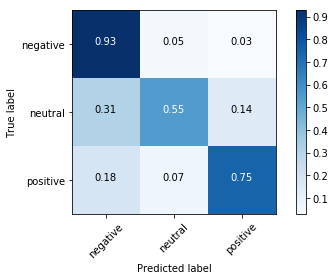

In [97]:
plt.figure()
metrics.confusion_matrix( normalized = True, plot = True )
plt.tight_layout()
plt.show()

It seems a lot of the neutral tweets are being absorbed by the negative sentiment. Its likely skewed toward sentiment because of the class imbalances ('neutral' words appear more in a negative context, purely due to the number of negative tweets, than otherwise so the language model has assigned them more negative sentiments). The same could be said for positive tweets to a lesser degree, but here the positive sentiment is strong enough that in most cases it can counteract the noise.

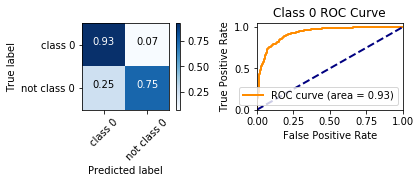

In [98]:
plt.figure()
plt.subplot(2, 2, 1)
b_metrics.confusion_matrix( 0, normalized = True, plot = True )
plt.subplot(2, 2, 2)
b_metrics.roc_curve( 0 )
plt.tight_layout()
plt.show()

Just more details as to what we saw above: strong precision and recall metrics with a large amount of false positives likely oweing to the dataset imbalance.

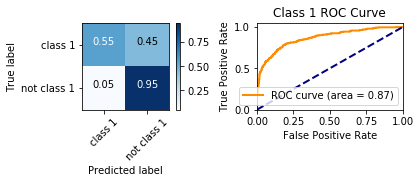

In [99]:
plt.figure()
plt.subplot(2, 2, 1)
b_metrics.confusion_matrix( 1, normalized = True, plot = True )
plt.subplot(2, 2, 2)
b_metrics.roc_curve( 1 )
plt.tight_layout()
plt.show()

The model seems to flip a coin whenever it comes across a neutral review but is at least sure when something isn't neutral. Weakest AUC score of the three, but still well above the random classifier line.

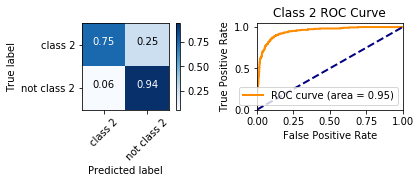

In [100]:
plt.figure()
plt.subplot(2, 2, 1)
b_metrics.confusion_matrix( 2, normalized = True, plot = True )
plt.subplot(2, 2, 2)
b_metrics.roc_curve( 2 )
plt.tight_layout()
plt.show()

As was said earlier: strong precision, losing some recall to the negative dataset imbalance. Very low false positive rate and combined with the best AUC score suggests that the model is most accurate with positive tweets - what the model has determined corresponds with 'positive sentiment' is the most accurate (but a lower recall suggests it hasn't found all the positive sentiment).

# Conclusions

Ignoring the dataset imbalance, our model seems to predict negative and positive sentiment well. It struggles with neutral sentiment and this could be down to a number of things: dataset imbalance, low quality labeling, noise introduced by positive and negative sentiment words or something else entirely. In a real world scenario, the performance on negative sentiment is likely the most desired aspect of the model, so we've got that going for us.

We could perhaps extend the model a number of ways. The most apparent would be applying the ULMFiT ideas - pretraining and fine tuning - to more state-of-the-art language model architectures. It seems the AWD-LSTM that was used currently competes evenly with other SotA approaches so this would be something that could be tackled as something new came out.

The ULMFiT paper, and many other language model approaches, makes use of bidirectional training - learning the language forwards and backwards and ensembling the resultant classifiers. This could also be trivially applied to this model. I however lack the pretrained weights for a backwards trained WikiText-103 model and so have avoided it. 

Speaking of ensembling methods: there is a lot of extra data in the twitter dataset that I have neglected to use. Airline, time of day, tweet length and whatever 'airline_sentiment_gold' is (gold standard data? who knows!), to name a few. If we created a model for predicting sentiment using all these other features and ensembled it with our language model, we could potentially score even higher. The ensembling technique could also be applied to our neutral sentiment. Our model struggles with this and its possible that the model itself just isn't going to be good at that kind of classification - not all models are good at everything. If we could find a model that performed better on neutral data we could combine that with our language model and improve performance on our weakest class.